### Imports

In [1]:
# Misc
import os
import sys
from rich import print

# Data Wrangling
import pandas as pd

# Data Manipulation
import torch

src_path = os.path.abspath(os.path.join(os.getcwd(), "src"))
sys.path.append(src_path)
from helpers import currency, notebook
from pipeline import ModelPipeline

notebook.add_cell_timer()

# Machine Learning 
from sklearn.ensemble import RandomForestClassifier
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.callbacks import VerboseCallback

### Base RFC

In [ ]:
rfc_pipeline = ModelPipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv')

# Feature Engineering
rfc_pipeline.add_date_features()
rfc_pipeline.drop_duplicates()
rfc_pipeline.apply_label_encoding(["Receiving Currency", "Payment Currency", "Payment Format", "Account.1", "Account"])
# pipeline.extract_graph_features(weight_col= 'Amount Paid')
rfc_pipeline.df

X_cols = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second']
y_col = 'Is Laundering'

# Train-Test-Validation Split
X_train, X_val, X_test, y_train, y_val, y_test = rfc_pipeline.split_train_test_val(
    X_cols= X_cols,
    y_col= y_col
)
X_train, X_test, X_val =  rfc_pipeline.numerical_scaling(['Amount Received', 'Amount Paid'])


print('Pre Processing done')

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

print('rfc trained')

# Train predictions
train_pred = clf.predict(X_train)
train_proba = clf.predict_proba(X_train)
print('train')

# Validation predictions
val_pred = clf.predict(X_val)
val_proba = clf.predict_proba(X_val)
print('val')

# Test predictions
test_pred = clf.predict(X_test)
test_proba = clf.predict_proba(X_test)

print('test')

# Evaluate Model Performance
slide_title = "Performance for RandomForestClassifier with Default Parameters and Standard Scaling"
metrics_summary = rfc_pipeline.result_metrics(slide_title,
    y_train, train_pred, train_proba,
    y_val, val_pred, val_proba,
    y_test, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)

### Base XGBoost

In [12]:
xgb_pipeline = ModelPipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv')

# Feature Engineering
xgb_pipeline.add_date_features()
xgb_pipeline.apply_label_encoding(["Receiving Currency", "Payment Currency", "Payment Format", "Account.1", "Account"])
# pipeline.extract_graph_features(weight_col= 'Amount Paid')
xgb_pipeline.df


,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,...,hour_of_day,day_of_week,seconds_since_midnight,timestamp_int,timestamp_scaled,day_sin,day_cos,time_of_day_sin,time_of_day_cos,is_weekend
0,10,942,10,900,3697.340000,12,3697.340000,12,5,0,...,0,3,1200,1.661992e+09,1.661992e+09,0.433884,-0.900969,0.087156,0.996195,0
1,3208,990,1,949,0.010000,12,0.010000,12,3,0,...,0,3,1200,1.661992e+09,1.661992e+09,0.433884,-0.900969,0.087156,0.996195,0
2,3209,991,3209,940,14675.570000,12,14675.570000,12,5,0,...,0,3,0,1.661990e+09,1.661990e+09,0.433884,-0.900969,0.000000,1.000000,0
3,12,997,12,945,2806.970000,12,2806.970000,12,5,0,...,0,3,120,1.661991e+09,1.661991e+09,0.433884,-0.900969,0.008727,0.999962,0
4,10,999,10,947,36682.970000,12,36682.970000,12,5,0,...,0,3,360,1.661991e+09,1.661991e+09,0.433884,-0.900969,0.026177,0.999657,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5078340,54219,495979,256398,419726,0.154978,1,0.154978,1,1,0,...,23,5,86220,1.662854e+09,1.662854e+09,-0.974928,-0.222521,-0.013090,0.999914,1
5078341,15,495988,256398,419726,0.108128,1,0.108128,1,1,0,...,23,5,84900,1.662853e+09,1.662853e+09,-0.974928,-0.222521,-0.108867,0.994056,1
5078342,154365,495980,256398,419726,0.004988,1,0.004988,1,1,0,...,23,5,85920,1.662854e+09,1.662854e+09,-0.974928,-0.222521,-0.034899,0.999391,1
5078343,256398,495978,256398,419726,0.038417,1,0.038417,1,1,0,...,23,5,85560,1.662854e+09,1.662854e+09,-0.974928,-0.222521,-0.061049,0.998135,1



⏱️ Execution time: 16.77s

⏱️ Execution time: 16.77s


In [13]:
xgb_pipeline.df.time_of_day

0          00:20:00
1          00:20:00
2          00:00:00
3          00:02:00
4          00:06:00
             ...   
5078340    23:57:00
5078341    23:35:00
5078342    23:52:00
5078343    23:46:00
5078344    23:37:00
Name: time_of_day, Length: 5078345, dtype: object


⏱️ Execution time: 0.01s

⏱️ Execution time: 0.01s


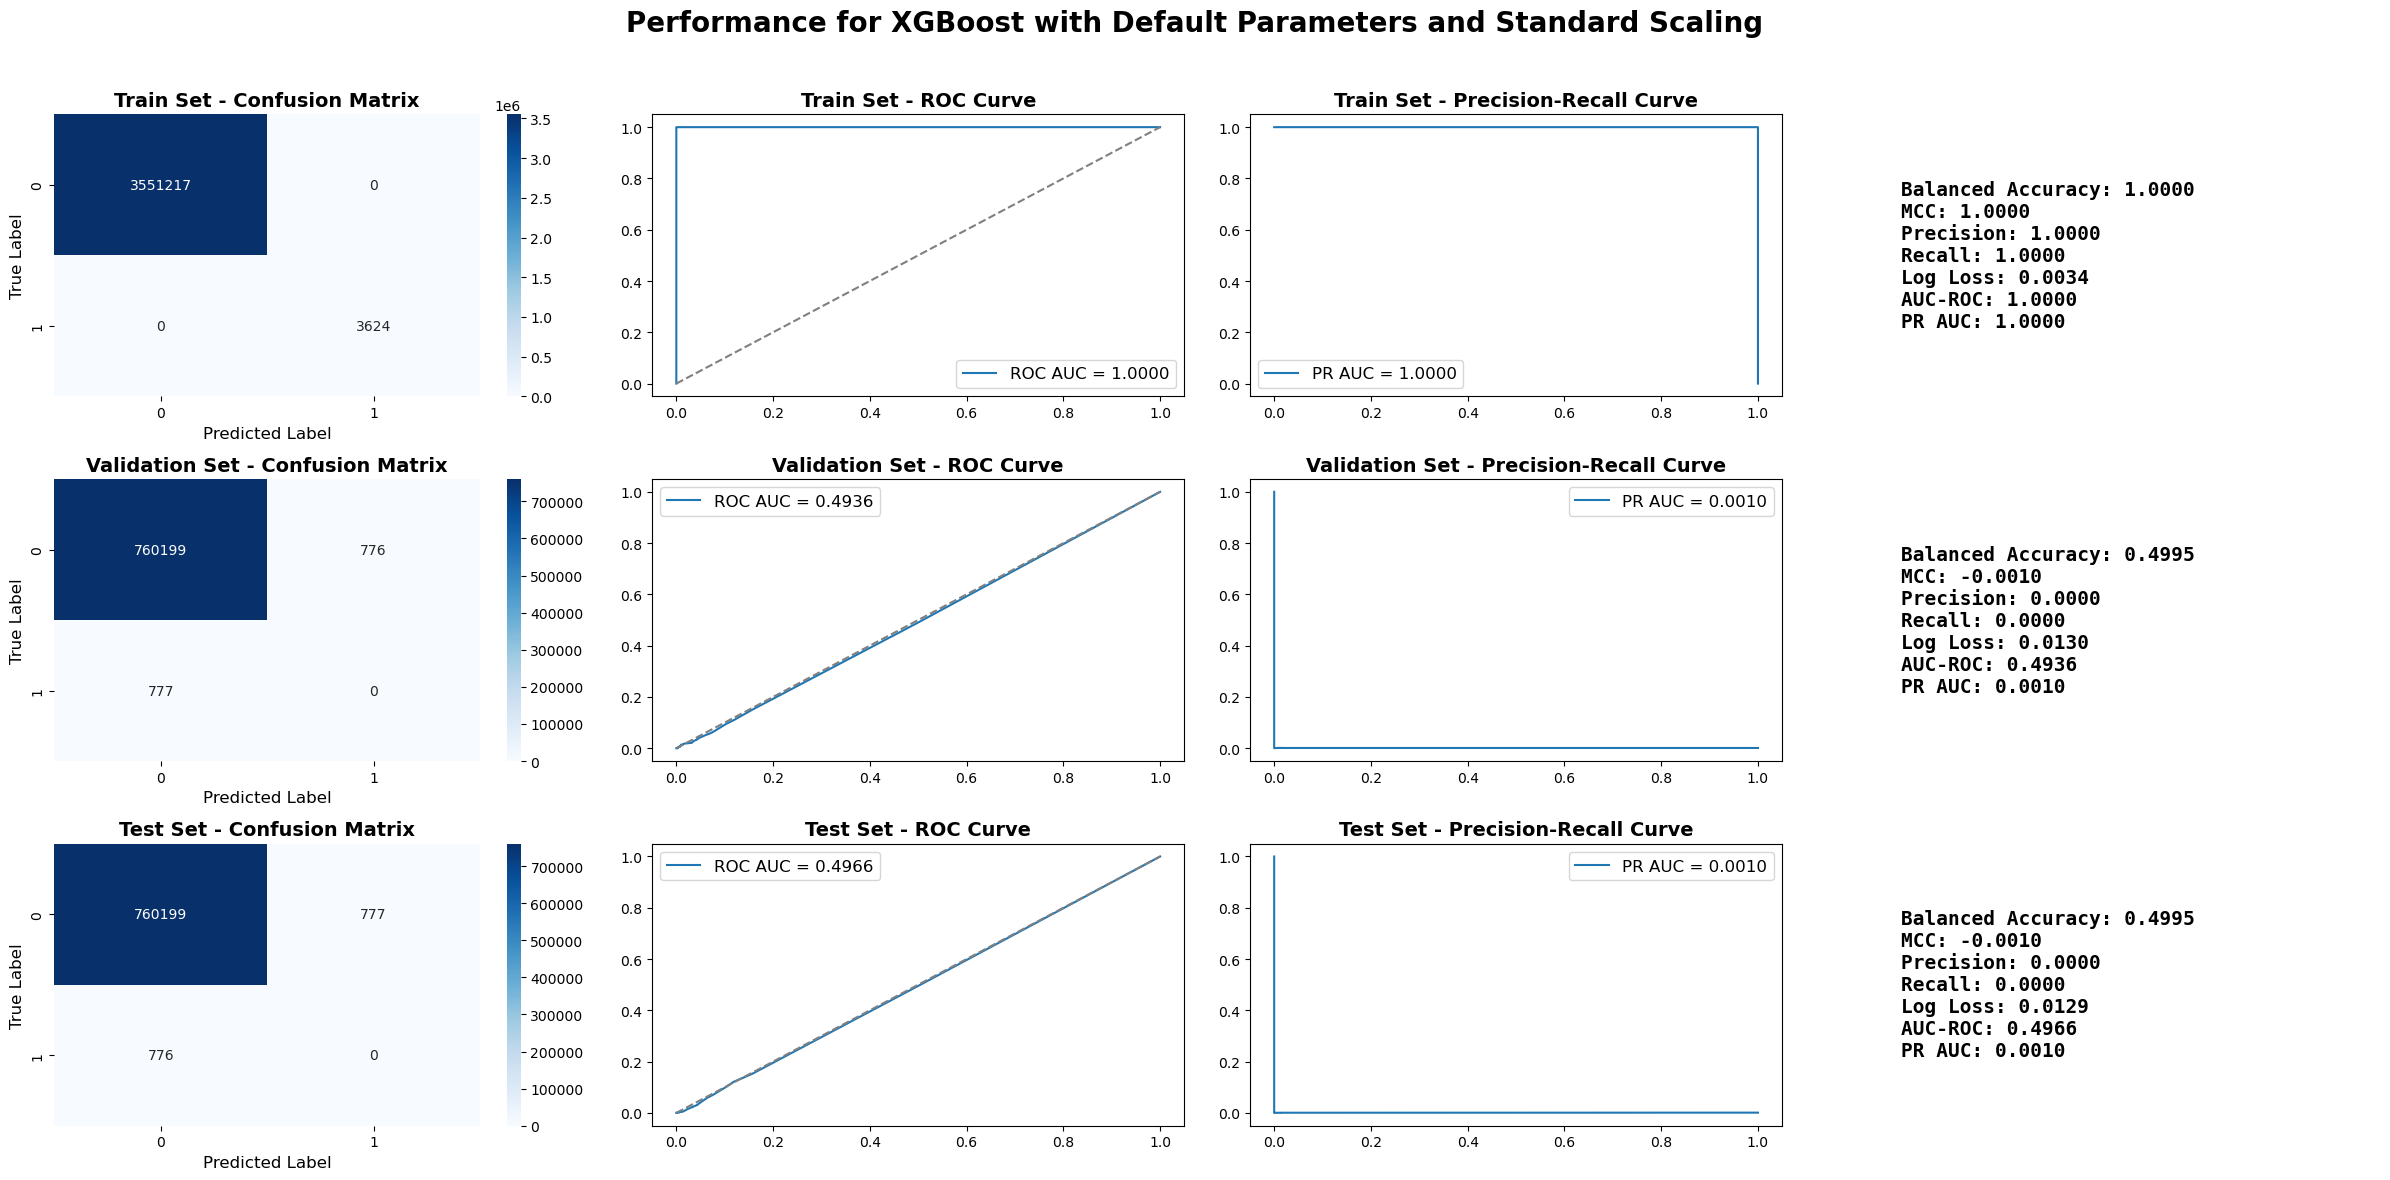


⏱️ Execution time: 53.46s

⏱️ Execution time: 53.46s


In [ ]:
import xgboost as xgb

# Define feature columns (excluding specific ones)
X_cols = [item for item in xgb_pipeline.df if item not in {'From Bank', 'Account', 'To Bank', 'Account.1', 'time_of_day'}]

y_col = 'Is Laundering'

# Train-Test-Validation Split
X_train, X_val, X_test, y_train, y_val, y_test = xgb_pipeline.split_train_test_val(
    X_cols=X_cols,
    y_col=y_col
)

# Apply numerical scaling
X_train, X_val, X_test = xgb_pipeline.numerical_scaling(['Amount Received', 'Amount Paid', 'timestamp_scaled'])

# Define model parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 8,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Initialize and train XGBoost model
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

# Train predictions
train_proba = model.predict_proba(X_train)[:, 1]  # Get probability of class 1
train_pred = (train_proba > 0.5).astype(int)

# Validation predictions
val_proba = model.predict_proba(X_val)[:, 1]
val_pred = (val_proba > 0.5).astype(int)

# Test predictions
test_proba = model.predict_proba(X_test)[:, 1]
test_pred = (test_proba > 0.5).astype(int)


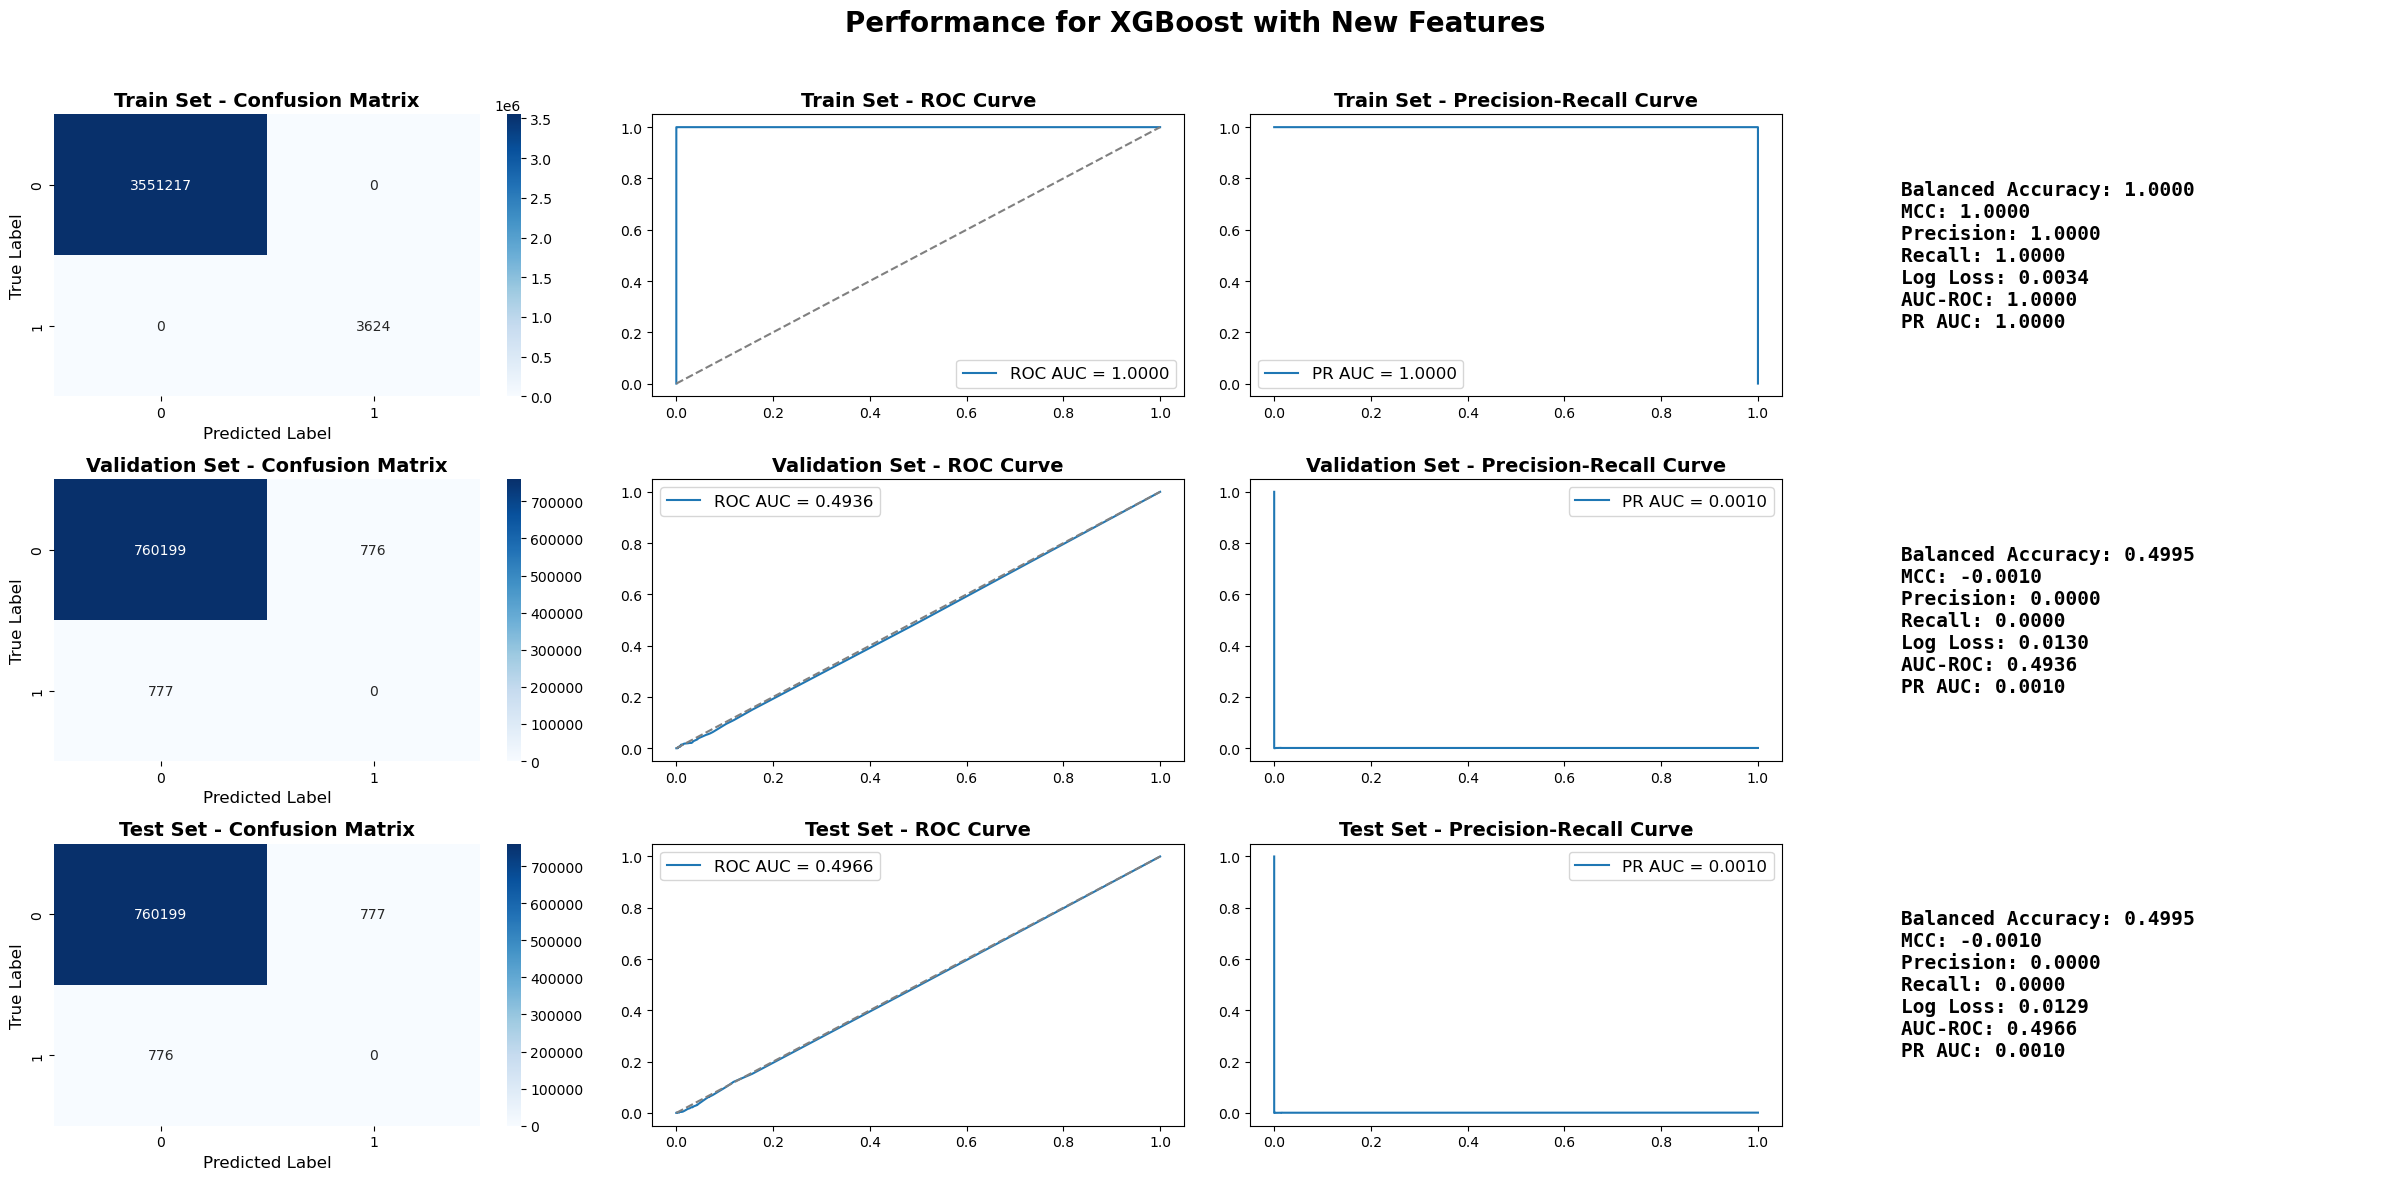


⏱️ Execution time: 9.35s

⏱️ Execution time: 9.35s


In [15]:

# Evaluate Model Performance
slide_title = "Performance for XGBoost with New Features"
metrics_summary = xgb_pipeline.result_metrics(
    slide_title,
    y_train, train_pred, train_proba,
    y_val, val_pred, val_proba,
    y_test, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)


### Simple GNN

In [ ]:
gnn_pipeline = ModelPipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv')

# Feature Engineering
gnn_pipeline.add_date_features()
gnn_pipeline.apply_label_encoding(["Receiving Currency", "Payment Currency", "Payment Format", "Account.1", "Account"])
# pipeline.extract_graph_features(weight_col= 'Amount Paid')
gnn_pipeline.df

X_cols = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second', "Account.1", "Account"]
y_col = 'Is Laundering'

# Train-Test-Validation Split
X_train, X_val, X_test, y_train, y_val, y_test = gnn_pipeline.split_train_test_val(
    X_cols= X_cols,
    y_col= y_col
)

X_train, X_test, X_val =  gnn_pipeline.numerical_scaling(['Amount Received', 'Amount Paid'])

edge_features = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second']

edges = ["Account", "Account.1"]

train_data, val_data, test_data = gnn_pipeline.generate_tensors(edge_features= edge_features,edges = edges)

class SimpleGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Activation Function
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Log softmax for classification
    
# Instantiate the model
model = SimpleGNN(input_dim=train_data.x.shape[1], hidden_dim=16, output_dim=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Move data to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_data = train_data.to(device)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

# Move validation and test data to device
val_data = val_data.to(device)
test_data = test_data.to(device)

# Get predictions for Train, Validation, and Test
model.eval()
with torch.no_grad():
    # Train Set Predictions
    train_out = model(train_data.x, train_data.edge_index)
    train_proba = torch.exp(train_out).cpu().numpy()  # Convert log-softmax to probabilities
    train_pred = train_proba.argmax(axis=1)  # Get predicted class
    
    # Validation Set Predictions
    val_out = model(val_data.x, val_data.edge_index)
    val_proba = torch.exp(val_out).cpu().numpy()
    val_pred = val_proba.argmax(axis=1)

    # Test Set Predictions
    test_out = model(test_data.x, test_data.edge_index)
    test_proba = torch.exp(test_out).cpu().numpy()
    test_pred = test_proba.argmax(axis=1)

y_train_np = train_data.y.cpu().numpy()
y_val_np = val_data.y.cpu().numpy()
y_test_np = test_data.y.cpu().numpy()

# Evaluate Model Performance
slide_title = "Performance of GNN Model with Standard Scaling"

metrics_summary = gnn_pipeline.result_metrics(
    slide_title,
    y_train_np, train_pred, train_proba,
    y_val_np, val_pred, val_proba,
    y_test_np, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)



### Architecture 1 GNN

In [ ]:
gnn1_pipeline = ModelPipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv')

# Feature Engineering
gnn1_pipeline.add_date_features()
gnn1_pipeline.apply_label_encoding(["Receiving Currency", "Payment Currency", "Payment Format", "Account.1", "Account"])
# pipeline.extract_graph_features(weight_col= 'Amount Paid')
gnn1_pipeline.df

X_cols = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second', "Account.1", "Account"]
y_col = 'Is Laundering'

# Train-Test-Validation Split
X_train, X_val, X_test, y_train, y_val, y_test = gnn1_pipeline.split_train_test_val(
    X_cols= X_cols,
    y_col= y_col
)

X_train, X_test, X_val =  gnn1_pipeline.numerical_scaling(['Amount Received', 'Amount Paid'])

edge_features = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second']

edges = ["Account", "Account.1"]

train_data, val_data, test_data = gnn1_pipeline.generate_tensors(edge_features= edge_features,edges = edges)

gnn1_pipeline
# Define the Enhanced GNN Model
class GNN_arch1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GNN_arch1, self).__init__()

        # Initial Graph Convolutional Layer (GCN)
        self.gcn1 = GCNConv(input_dim, hidden_dim)

        # Graph Attention Layer (GAT)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=False)

        # Fully Connected Layer for Node Classification
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        # Apply GCN
        x = self.gcn1(x, edge_index)
        x = F.relu(x)

        # Apply GAT for attention-based feature learning
        x = self.gat1(x, edge_index)
        x = F.relu(x)

        # Fully connected layers for **node-level classification**
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)  
    
# Instantiate the model
model = GNN_arch1(input_dim=train_data.x.shape[1], hidden_dim=16, output_dim=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Move data to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_data = train_data.to(device)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

# Move validation and test data to device
val_data = val_data.to(device)
test_data = test_data.to(device)

# Get predictions for Train, Validation, and Test
model.eval()
with torch.no_grad():
    # Train Set Predictions
    train_out = model(train_data.x, train_data.edge_index)
    train_proba = torch.exp(train_out).cpu().numpy()  # Convert log-softmax to probabilities
    train_pred = train_proba.argmax(axis=1)  # Get predicted class
    
    # Validation Set Predictions
    val_out = model(val_data.x, val_data.edge_index)
    val_proba = torch.exp(val_out).cpu().numpy()
    val_pred = val_proba.argmax(axis=1)

    # Test Set Predictions
    test_out = model(test_data.x, test_data.edge_index)
    test_proba = torch.exp(test_out).cpu().numpy()
    test_pred = test_proba.argmax(axis=1)

y_train_np = train_data.y.cpu().numpy()
y_val_np = val_data.y.cpu().numpy()
y_test_np = test_data.y.cpu().numpy()

# Evaluate Model Performance
slide_title = "Performance of Architecture 1 GNN Model with Standard Scaling"

metrics_summary = gnn1_pipeline.result_metrics(
    slide_title,
    y_train_np, train_pred, train_proba,
    y_val_np, val_pred, val_proba,
    y_test_np, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)



### Optimizing XGBoost using Bayesian 

Data Ready

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 266.3703
Function value obtained: -0.9064
Current minimum: -0.9064
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 397.6856
Function value obtained: -0.9183
Current minimum: -0.9183
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 805.5471
Function value obtained: -0.9216
Current minimum: -0.9216
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 657.2687
Function value obtained: -0.9226
Current minimum: -0.9226
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 335.2878
Function valu

Model Optimized

Best parameters:
OrderedDict([('colsample_bytree', 0.5269980554095974), ('gamma', 3), ('learning_rate', 0.1843674059271223), 
('max_depth', 3), ('min_child_weight', 4), ('n_estimators', 646), ('subsample', 0.8068600983087237)])

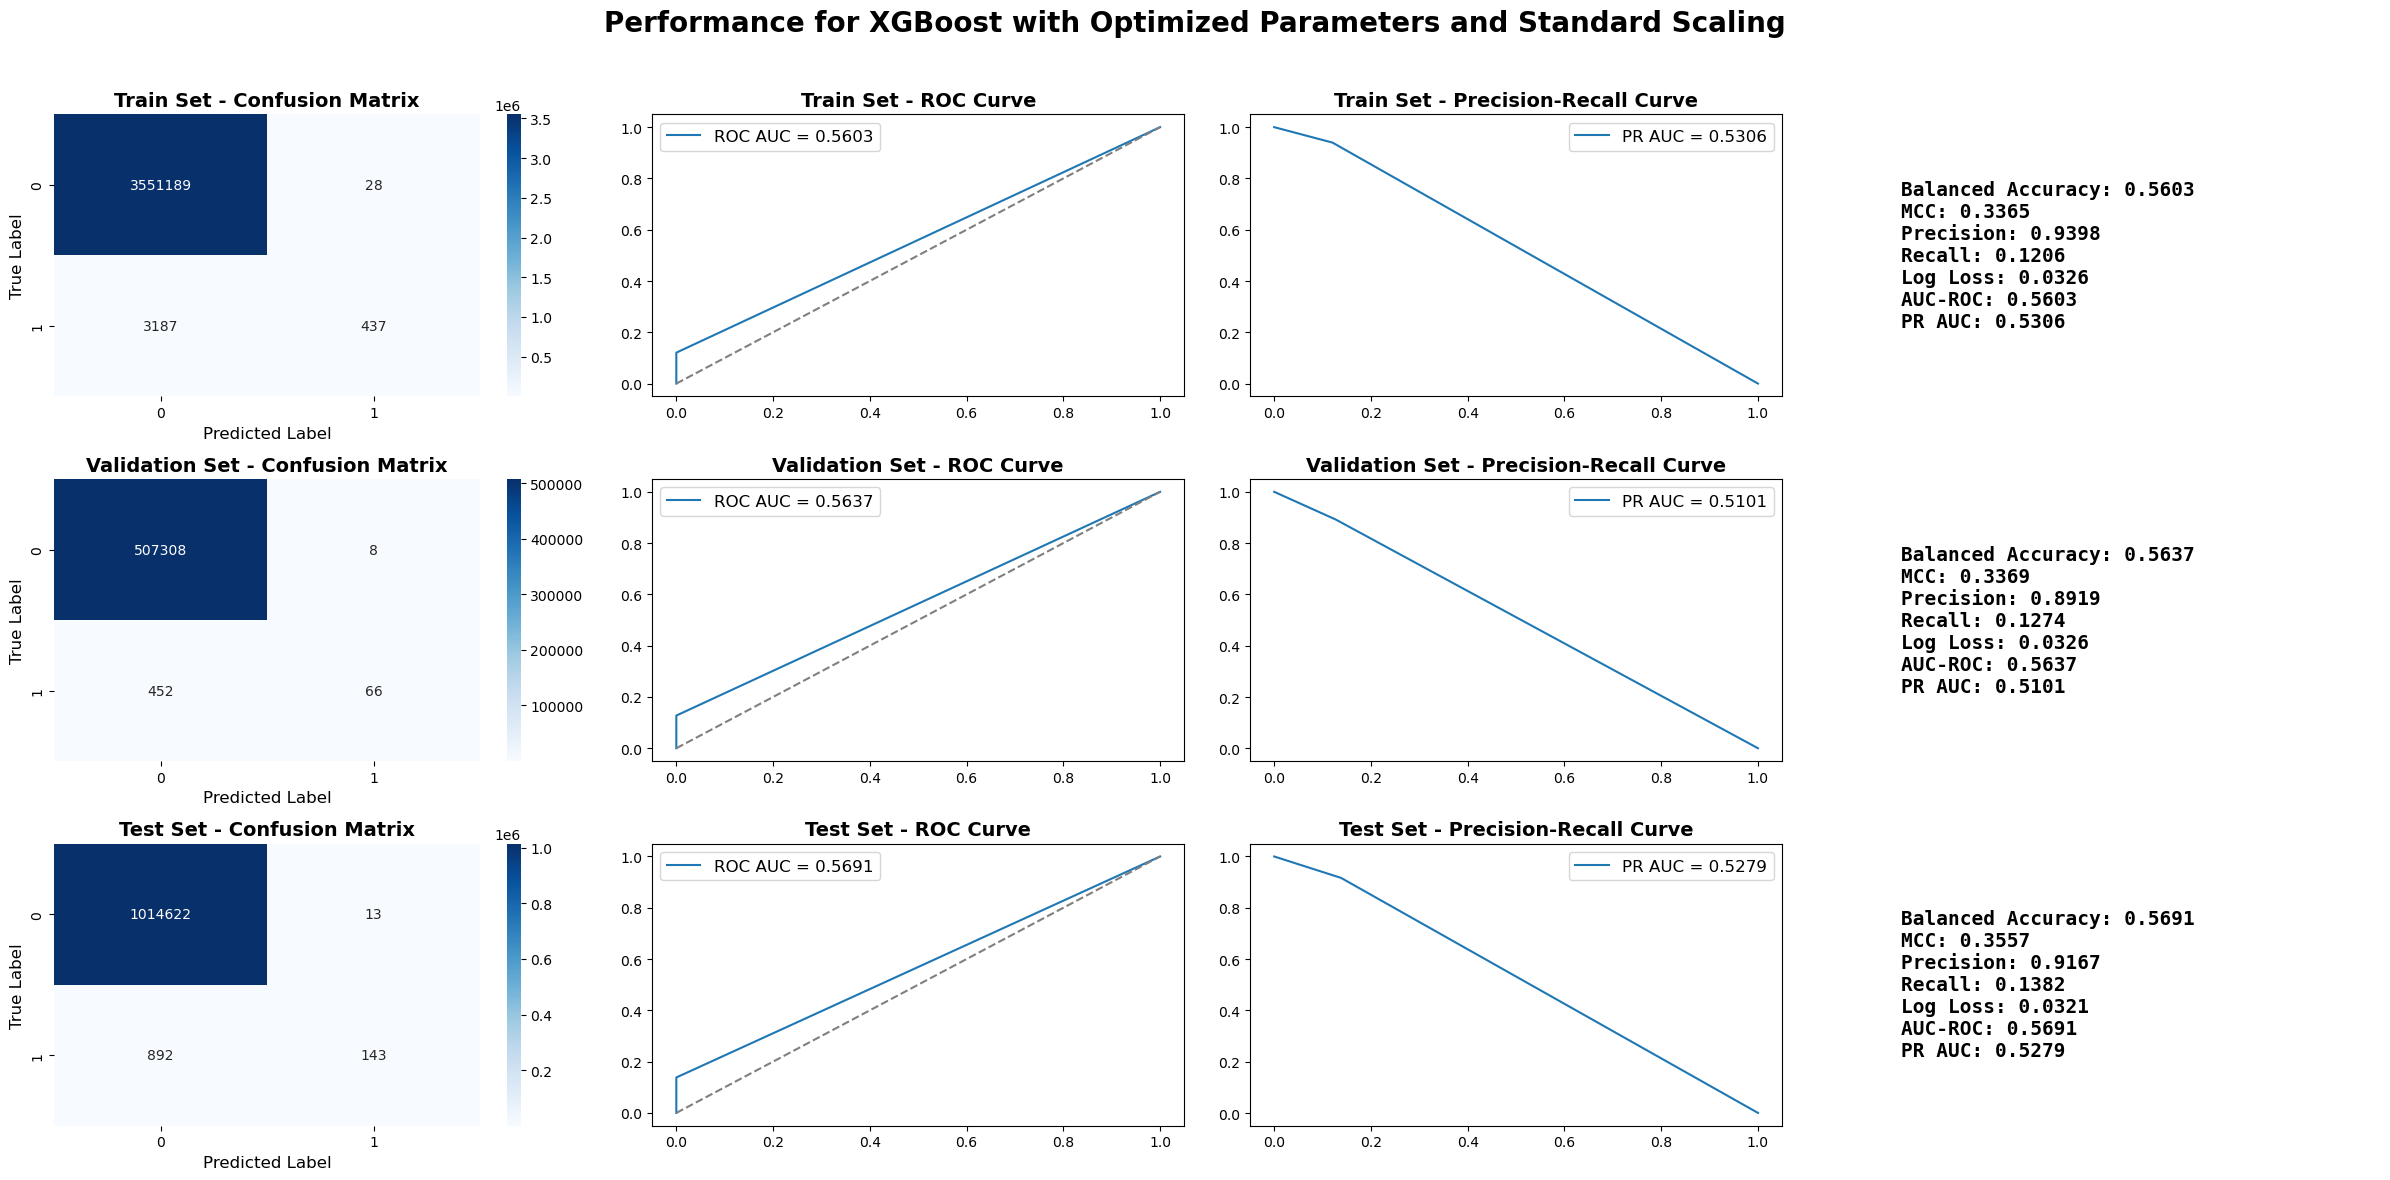


⏱️ Execution time: 11219.58s


In [ ]:
xgb_pipeline = ModelPipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv')

# Feature Engineering
xgb_pipeline.add_date_features()
xgb_pipeline.apply_label_encoding(["Receiving Currency", "Payment Currency", "Payment Format", "Account.1", "Account"])
# pipeline.extract_graph_features(weight_col= 'Amount Paid')
xgb_pipeline.df

X_cols = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second']
y_col = 'Is Laundering'

# Train-Test-Validation Split
X_train, X_val, X_test, y_train, y_val, y_test = xgb_pipeline.split_train_test_val(
    X_cols= X_cols,
    y_col= y_col
)

X_train, X_test, X_val =  xgb_pipeline.numerical_scaling(['Amount Received', 'Amount Paid'])

print('Data Ready')
# Define search space
param_space = {
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'n_estimators': (100, 1000),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'min_child_weight': (1, 10),
    'gamma': (0, 5)
}

# Initialize Bayesian Search
bayes_search = BayesSearchCV(
    xgb.XGBClassifier(eval_metric='auc', random_state=42),
    param_space,
    n_iter=20,  # Number of parameter settings to test
    cv=2,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit Bayesian search
bayes_search.fit(X_train, y_train, callback=VerboseCallback(n_total=5))

print('Model Optimized')
# Best model

best_xgb_model = bayes_search.best_estimator_
print("Best parameters:", bayes_search.best_params_)

# Train predictions
train_proba = best_xgb_model.predict(X_train)
train_pred = (train_proba > 0.5).astype(int)

# Validation predictions
val_proba = best_xgb_model.predict(X_val)
val_pred = (val_proba > 0.5).astype(int)

# Test predictions
test_proba = best_xgb_model.predict(X_test)
test_pred = (test_proba > 0.5).astype(int)


# Evaluate Model Performance
slide_title = "Performance for XGBoost with Optimized Parameters and Standard Scaling"
metrics_summary = xgb_pipeline.result_metrics(slide_title,
    y_train, train_pred, train_proba,
    y_val, val_pred, val_proba,
    y_test, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)

[INFO] Starting Feature Engineering...

[INFO] Feature Engineering Completed.

[INFO] Splitting Data into Train, Validation, and Test sets...

[INFO] Data Splitting Completed.

[INFO] Scaling Numerical Features...

[INFO] Scaling Completed.

[INFO] Data Ready for Training.

[INFO] Initializing Bayesian Optimization...

/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[INFO] Starting Hyperparameter Optimization with Validation Set...

/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Iteration No: 1 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49526
[4]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49526
[5]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49526
[6]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49526
[7]	validation_0-auc:0.49949
[6]	validation_0-auc:0.49526
[8]	validation_0-auc:0.49949
[9]	validation_0-auc:0.49949
[7]	validation_0-auc:0.49526
[8]	validation_0-auc:0.49526
[9]	validation_0-auc:0.49526
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 21.5467
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 2 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49515
[2]	validation_0-auc:0.49520
[3]	validation_0-auc:0.49520
[3]	validation_0-auc:0.49497
[4]	validation_0-auc:0.49497
[5]	validation_0-auc:0.49497
[4]	validation_0-auc:0.49520
[6]	validation_0-auc:0.49497
[7]	validation_0-auc:0.49497
[8]	validation_0-auc:0.49497
[5]	validation_0-auc:0.49506
[9]	validation_0-auc:0.49497
[6]	validation_0-auc:0.49505
[7]	validation_0-auc:0.49508
[8]	validation_0-auc:0.49508
[9]	validation_0-auc:0.49508
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 14.1245
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 3 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49523
[3]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49516
[6]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49516
[7]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49516
[8]	validation_0-auc:0.49949
[9]	validation_0-auc:0.49949
[6]	validation_0-auc:0.49517
[7]	validation_0-auc:0.49515
[8]	validation_0-auc:0.49515
[9]	validation_0-auc:0.49515
[10]	validation_0-auc:0.49515
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 14.3170
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 4 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49509
[4]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49509
[5]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49509
[6]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49509
[7]	validation_0-auc:0.49949
[6]	validation_0-auc:0.49509
[8]	validation_0-auc:0.49949
[9]	validation_0-auc:0.49949
[7]	validation_0-auc:0.49511
[8]	validation_0-auc:0.49511
[9]	validation_0-auc:0.49511
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 13.2959
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 5 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49526
[5]	validation_0-auc:0.49949
[6]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49526
[7]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49526
[8]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49526
[9]	validation_0-auc:0.49949
[10]	validation_0-auc:0.49949
[6]	validation_0-auc:0.49526
[7]	validation_0-auc:0.49526
[8]	validation_0-auc:0.49526
[9]	validation_0-auc:0.49526
[10]	validation_0-auc:0.49526
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 12.9005
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 6 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49523
[4]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49523
[5]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49523
[6]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49523
[7]	validation_0-auc:0.49949
[6]	validation_0-auc:0.49523
[8]	validation_0-auc:0.49949
[9]	validation_0-auc:0.49949
[7]	validation_0-auc:0.49523
[8]	validation_0-auc:0.49523
[9]	validation_0-auc:0.49523
[10]	validation_0-auc:0.49523
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 11.9199
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 7 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49523
[5]	validation_0-auc:0.49949
[6]	validation_0-auc:0.49949
[7]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49517
[8]	validation_0-auc:0.49949
[9]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49515
[5]	validation_0-auc:0.49512
[6]	validation_0-auc:0.49513
[7]	validation_0-auc:0.49512
[8]	validation_0-auc:0.49512
[9]	validation_0-auc:0.49512
[10]	validation_0-auc:0.49512
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 15.4822
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 8 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49538
[2]	validation_0-auc:0.49538
[3]	validation_0-auc:0.49538
[3]	validation_0-auc:0.49538
[4]	validation_0-auc:0.49538
[4]	validation_0-auc:0.49527
[5]	validation_0-auc:0.49538
[6]	validation_0-auc:0.49538
[5]	validation_0-auc:0.49517
[7]	validation_0-auc:0.49538
[8]	validation_0-auc:0.49538
[6]	validation_0-auc:0.49516
[9]	validation_0-auc:0.49538
[10]	validation_0-auc:0.49538
[7]	validation_0-auc:0.49519
[8]	validation_0-auc:0.49519
[9]	validation_0-auc:0.49519
[10]	validation_0-auc:0.49519
Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 12.8719
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 9 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49503
[2]	validation_0-auc:0.49506
[3]	validation_0-auc:0.49506
[3]	validation_0-auc:0.49501
[4]	validation_0-auc:0.49501
[4]	validation_0-auc:0.49515
[5]	validation_0-auc:0.49501
[6]	validation_0-auc:0.49501
[7]	validation_0-auc:0.49501
[5]	validation_0-auc:0.49530
[8]	validation_0-auc:0.49501
[9]	validation_0-auc:0.49501
[6]	validation_0-auc:0.49525
[7]	validation_0-auc:0.49513
[8]	validation_0-auc:0.49513
[9]	validation_0-auc:0.49513
Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 13.3343
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 10 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49519
[4]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49519
[6]	validation_0-auc:0.49949
[7]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49522
[8]	validation_0-auc:0.49949
[9]	validation_0-auc:0.49949
[10]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49523
[6]	validation_0-auc:0.49525
[7]	validation_0-auc:0.49507
[8]	validation_0-auc:0.49507
[9]	validation_0-auc:0.49507
[10]	validation_0-auc:0.49507
Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 13.4288
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 11 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49496
[2]	validation_0-auc:0.49509
[3]	validation_0-auc:0.49509
[3]	validation_0-auc:0.49496
[4]	validation_0-auc:0.49496
[4]	validation_0-auc:0.49525
[5]	validation_0-auc:0.49496
[5]	validation_0-auc:0.49525
[6]	validation_0-auc:0.49496
[6]	validation_0-auc:0.49526
[7]	validation_0-auc:0.49496
[8]	validation_0-auc:0.49496
[7]	validation_0-auc:0.49523
[9]	validation_0-auc:0.49496
[8]	validation_0-auc:0.49523
[10]	validation_0-auc:0.49508
[9]	validation_0-auc:0.49523
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 8.4998
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 12 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49520
[3]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49520
[4]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49520
[5]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49520
[6]	validation_0-auc:0.49949
[6]	validation_0-auc:0.49520
[7]	validation_0-auc:0.49949
[8]	validation_0-auc:0.49949
[7]	validation_0-auc:0.49520
[9]	validation_0-auc:0.49949
[8]	validation_0-auc:0.49520
[10]	validation_0-auc:0.49949
[9]	validation_0-auc:0.49520
[10]	validation_0-auc:0.49520
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 9.2813
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 13 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49491
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49493
[3]	validation_0-auc:0.49491
[3]	validation_0-auc:0.49493
[4]	validation_0-auc:0.49506
[4]	validation_0-auc:0.49493
[5]	validation_0-auc:0.49493
[5]	validation_0-auc:0.49506
[6]	validation_0-auc:0.49493
[7]	validation_0-auc:0.49493
[8]	validation_0-auc:0.49493
[6]	validation_0-auc:0.49507
[9]	validation_0-auc:0.49493
[10]	validation_0-auc:0.49495
[7]	validation_0-auc:0.49506
[8]	validation_0-auc:0.49506
[9]	validation_0-auc:0.49506
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 10.3728
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 14 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49520
[2]	validation_0-auc:0.49493
[3]	validation_0-auc:0.49520
[3]	validation_0-auc:0.49493
[4]	validation_0-auc:0.49520
[4]	validation_0-auc:0.49493
[5]	validation_0-auc:0.49520
[5]	validation_0-auc:0.49493
[6]	validation_0-auc:0.49493
[6]	validation_0-auc:0.49520
[7]	validation_0-auc:0.49493
[7]	validation_0-auc:0.49517
[8]	validation_0-auc:0.49493
[9]	validation_0-auc:0.49493
[8]	validation_0-auc:0.49517
[10]	validation_0-auc:0.49506
[9]	validation_0-auc:0.49517
[10]	validation_0-auc:0.49517
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 7.3595
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 15 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49527
[2]	validation_0-auc:0.49514
[3]	validation_0-auc:0.49526
[3]	validation_0-auc:0.49508
[4]	validation_0-auc:0.49508
[5]	validation_0-auc:0.49508
[4]	validation_0-auc:0.49516
[6]	validation_0-auc:0.49508
[7]	validation_0-auc:0.49508
[5]	validation_0-auc:0.49527
[8]	validation_0-auc:0.49508
[9]	validation_0-auc:0.49508
[6]	validation_0-auc:0.49519
[7]	validation_0-auc:0.49523
[8]	validation_0-auc:0.49477
[9]	validation_0-auc:0.49477
[10]	validation_0-auc:0.49463
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 11.4656
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 16 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49503
[2]	validation_0-auc:0.49496
[3]	validation_0-auc:0.49503
[3]	validation_0-auc:0.49496
[4]	validation_0-auc:0.49496
[4]	validation_0-auc:0.49519
[5]	validation_0-auc:0.49496
[5]	validation_0-auc:0.49519
[6]	validation_0-auc:0.49496
[6]	validation_0-auc:0.49519
[7]	validation_0-auc:0.49496
[8]	validation_0-auc:0.49496
[7]	validation_0-auc:0.49518
[9]	validation_0-auc:0.49496
[8]	validation_0-auc:0.49518
[9]	validation_0-auc:0.49518
[10]	validation_0-auc:0.49519
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 8.1200
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 17 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49503
[3]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49485
[5]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49485
[6]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49485
[7]	validation_0-auc:0.49949
[8]	validation_0-auc:0.49949
[6]	validation_0-auc:0.49487
[9]	validation_0-auc:0.49949
[10]	validation_0-auc:0.49949
[7]	validation_0-auc:0.49505
[8]	validation_0-auc:0.49505
[9]	validation_0-auc:0.49505
[10]	validation_0-auc:0.49505
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 10.5654
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 18 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49945
[3]	validation_0-auc:0.49945
[4]	validation_0-auc:0.49945
[4]	validation_0-auc:0.49945
[5]	validation_0-auc:0.49945
[5]	validation_0-auc:0.49945
[6]	validation_0-auc:0.49945
[6]	validation_0-auc:0.49945
[7]	validation_0-auc:0.49520
[7]	validation_0-auc:0.49499
[8]	validation_0-auc:0.49520
[8]	validation_0-auc:0.49499
[9]	validation_0-auc:0.49520
[9]	validation_0-auc:0.49499
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 9.5125
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 19 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49538
[2]	validation_0-auc:0.49538
[3]	validation_0-auc:0.49538
[3]	validation_0-auc:0.49538
[4]	validation_0-auc:0.49538
[5]	validation_0-auc:0.49538
[4]	validation_0-auc:0.49535
[6]	validation_0-auc:0.49538
[7]	validation_0-auc:0.49538
[5]	validation_0-auc:0.49535
[8]	validation_0-auc:0.49538
[9]	validation_0-auc:0.49538
[6]	validation_0-auc:0.49517
[10]	validation_0-auc:0.49526
[7]	validation_0-auc:0.49514
[8]	validation_0-auc:0.49591
[9]	validation_0-auc:0.49591
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 12.4015
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 20 started. Searching for the next optimal point.


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49503
[3]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49503
[4]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49503
[5]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49503
[6]	validation_0-auc:0.49949
[6]	validation_0-auc:0.49503
[7]	validation_0-auc:0.49949
[8]	validation_0-auc:0.49949
[7]	validation_0-auc:0.49504
[9]	validation_0-auc:0.49949
[8]	validation_0-auc:0.49504
[9]	validation_0-auc:0.49504
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 10.3308
Function value obtained: -1.0000
Current minimum: -1.0000


/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.49949
[1]	validation_0-auc:0.49949
[2]	validation_0-auc:0.49949
[3]	validation_0-auc:0.49949
[4]	validation_0-auc:0.49949
[5]	validation_0-auc:0.49508
[6]	validation_0-auc:0.49508
[7]	validation_0-auc:0.49508
[8]	validation_0-auc:0.49508
[9]	validation_0-auc:0.49508
[10]	validation_0-auc:0.49508


[INFO] Hyperparameter Optimization Completed in 246.62 seconds.

Best parameters found:
OrderedDict([('colsample_bytree', 0.992867255999416), ('gamma', 3), ('learning_rate', 0.044809400721591244), 
('max_depth', 10), ('min_child_weight', 3), ('n_estimators', 244), ('subsample', 0.6440055820287032)])

[INFO] Making Predictions on Train, Validation, and Test sets...

[INFO] Predictions Completed.

[INFO] Evaluating Model Performance...

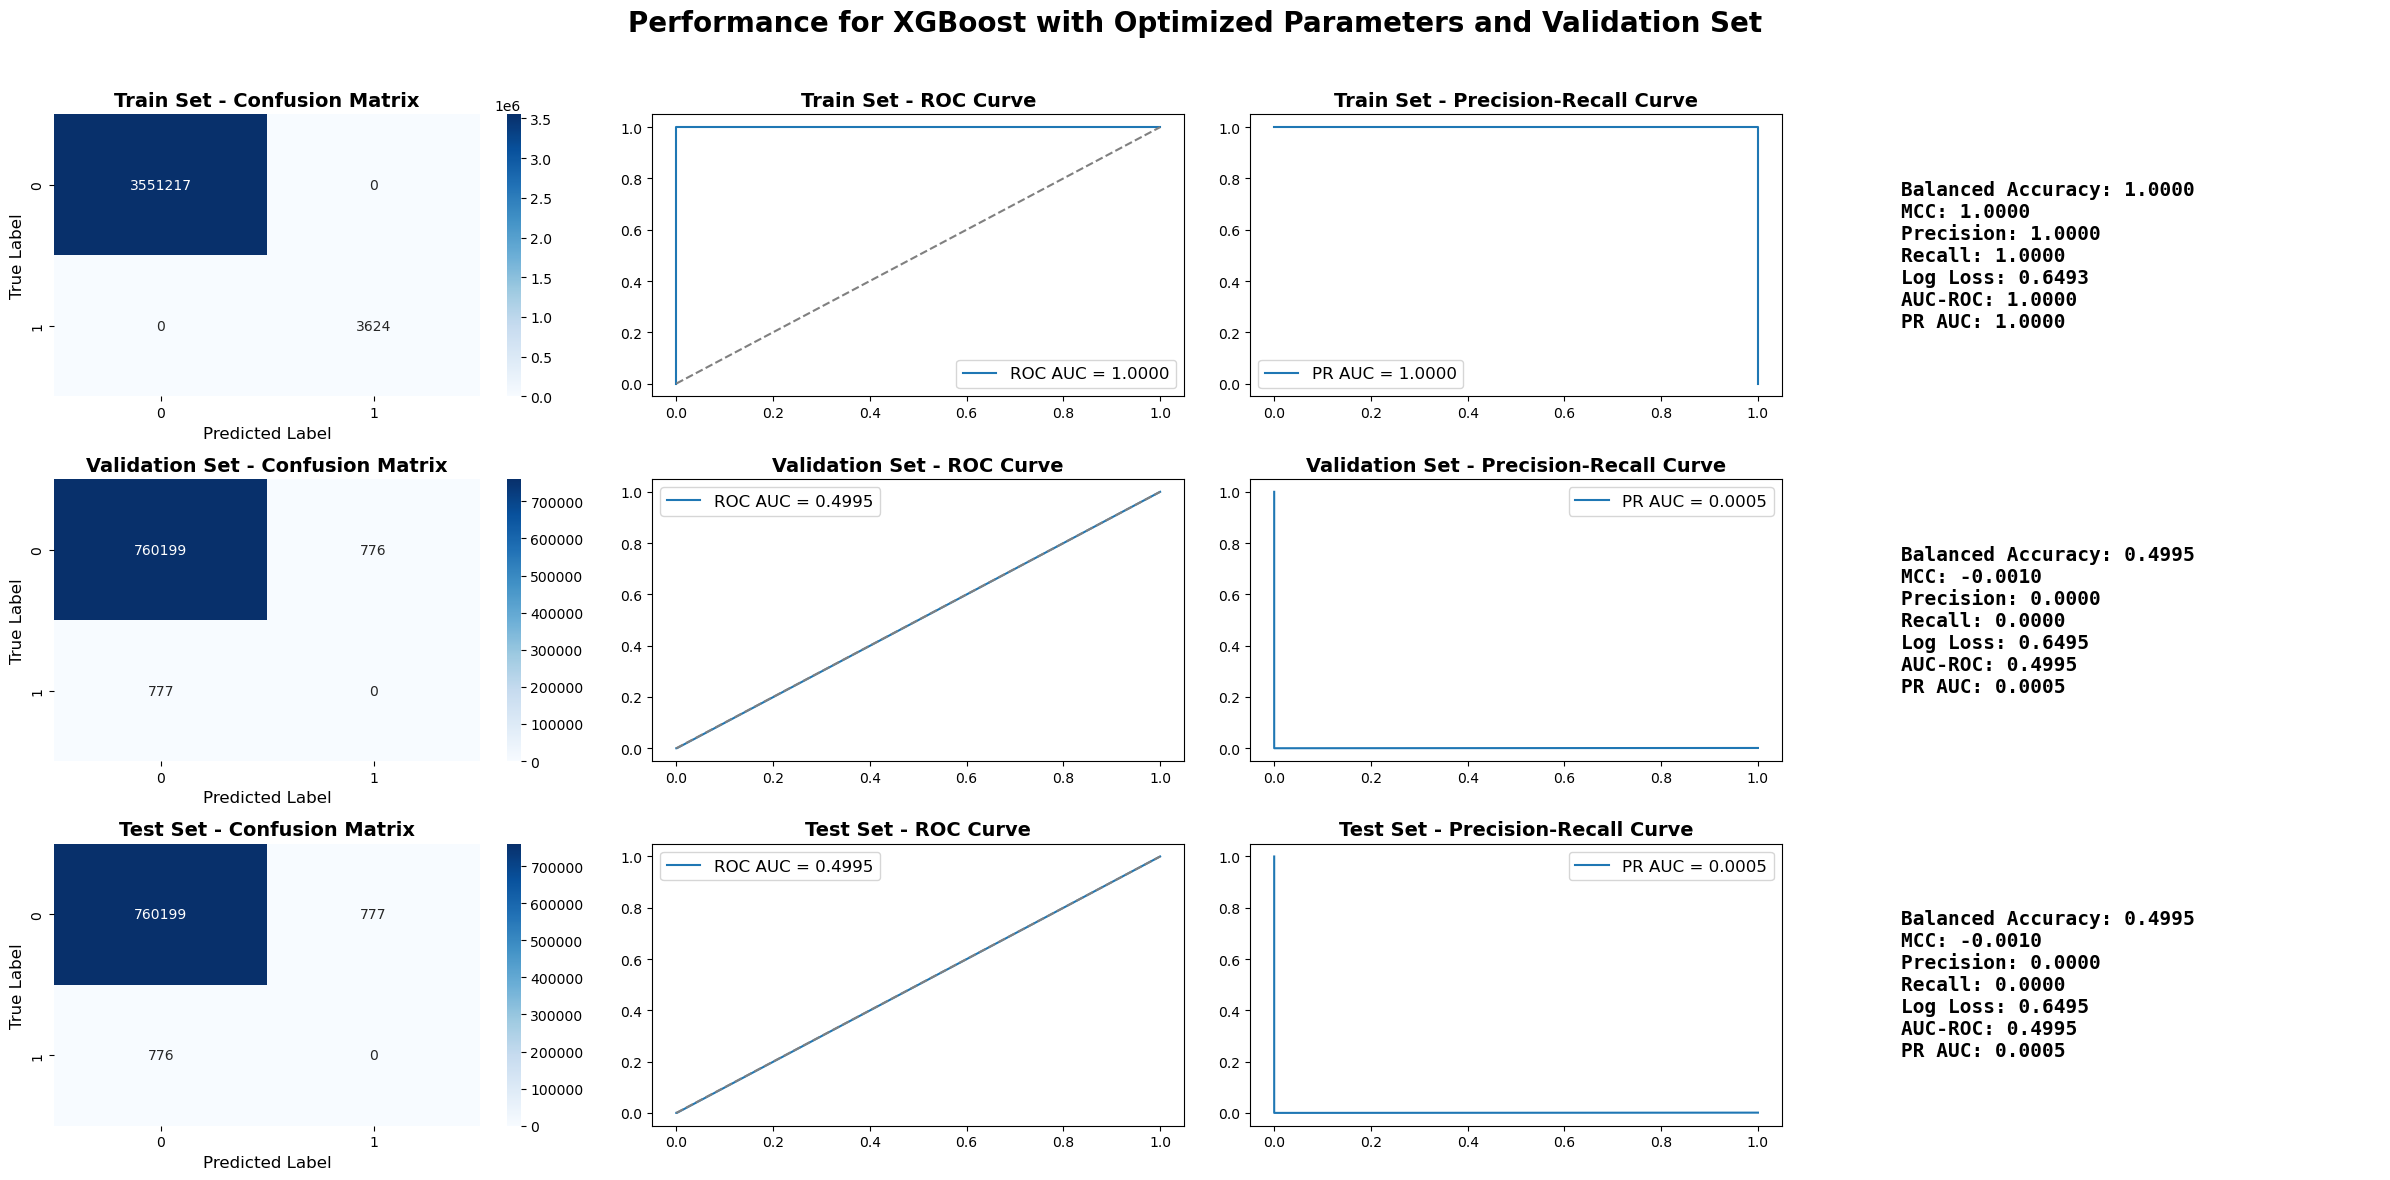

[INFO] Model Evaluation Completed.


⏱️ Execution time: 271.82s

⏱️ Execution time: 271.82s


In [ ]:
import time
from skopt.callbacks import VerboseCallback
from skopt import BayesSearchCV
import xgboost as xgb

# Define pipeline
xgb2_pipeline = ModelPipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv')

# Feature Engineering
print("[INFO] Starting Feature Engineering...")
xgb2_pipeline.add_date_features()
xgb2_pipeline.apply_label_encoding(["Receiving Currency", "Payment Currency", "Payment Format", "Account.1", "Account"])
print("[INFO] Feature Engineering Completed.")

# Define feature columns (excluding specific ones)
X_cols = [item for item in xgb_pipeline.df if item not in {'From Bank', 'Account', 'To Bank', 'Account.1', 'time_of_day'}]

y_col = 'Is Laundering'


# Train-Test-Validation Split
print("[INFO] Splitting Data into Train, Validation, and Test sets...")
X_train, X_val, X_test, y_train, y_val, y_test = xgb2_pipeline.split_train_test_val(X_cols=X_cols, y_col=y_col)
print("[INFO] Data Splitting Completed.")

# Feature Scaling
print("[INFO] Scaling Numerical Features...")
X_train, X_val, X_test = xgb2_pipeline.numerical_scaling(['Amount Received', 'Amount Paid', 'timestamp_scaled'])
print("[INFO] Scaling Completed.")

print("[INFO] Data Ready for Training.")

# Define search space
param_space = {
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'n_estimators': (100, 1000),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'min_child_weight': (1, 10),
    'gamma': (0, 5)
}

# Initialize Bayesian Search
print("[INFO] Initializing Bayesian Optimization...")

bayes_search2 = BayesSearchCV(
    xgb.XGBClassifier(
        eval_metric='auc', 
        random_state=42,
        use_label_encoder=False
    ),
    param_space,
    n_iter=20,  # ✅ Increased iterations for better tuning
    cv=2,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit Bayesian search with Validation Set and Early Stopping
start_time = time.time()
print("[INFO] Starting Hyperparameter Optimization with Validation Set...")

bayes_search2.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # ✅ Use Validation Set
    early_stopping_rounds=10,  # ✅ Stop if no improvement for 10 rounds
    verbose=True,  # ✅ Print logs
    callback=VerboseCallback(n_total=20)
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"[INFO] Hyperparameter Optimization Completed in {elapsed_time:.2f} seconds.")

# Best model
best_xgb_model2 = bayes_search2.best_estimator_
print("Best parameters found:", bayes_search2.best_params_)

# Train predictions
print("[INFO] Making Predictions on Train, Validation, and Test sets...")
train_proba = best_xgb_model2.predict_proba(X_train)[:, 1]
train_pred = (train_proba > 0.5).astype(int)

val_proba = best_xgb_model2.predict_proba(X_val)[:, 1]
val_pred = (val_proba > 0.5).astype(int)

test_proba = best_xgb_model2.predict_proba(X_test)[:, 1]
test_pred = (test_proba > 0.5).astype(int)
print("[INFO] Predictions Completed.")


[INFO] Evaluating Model Performance...

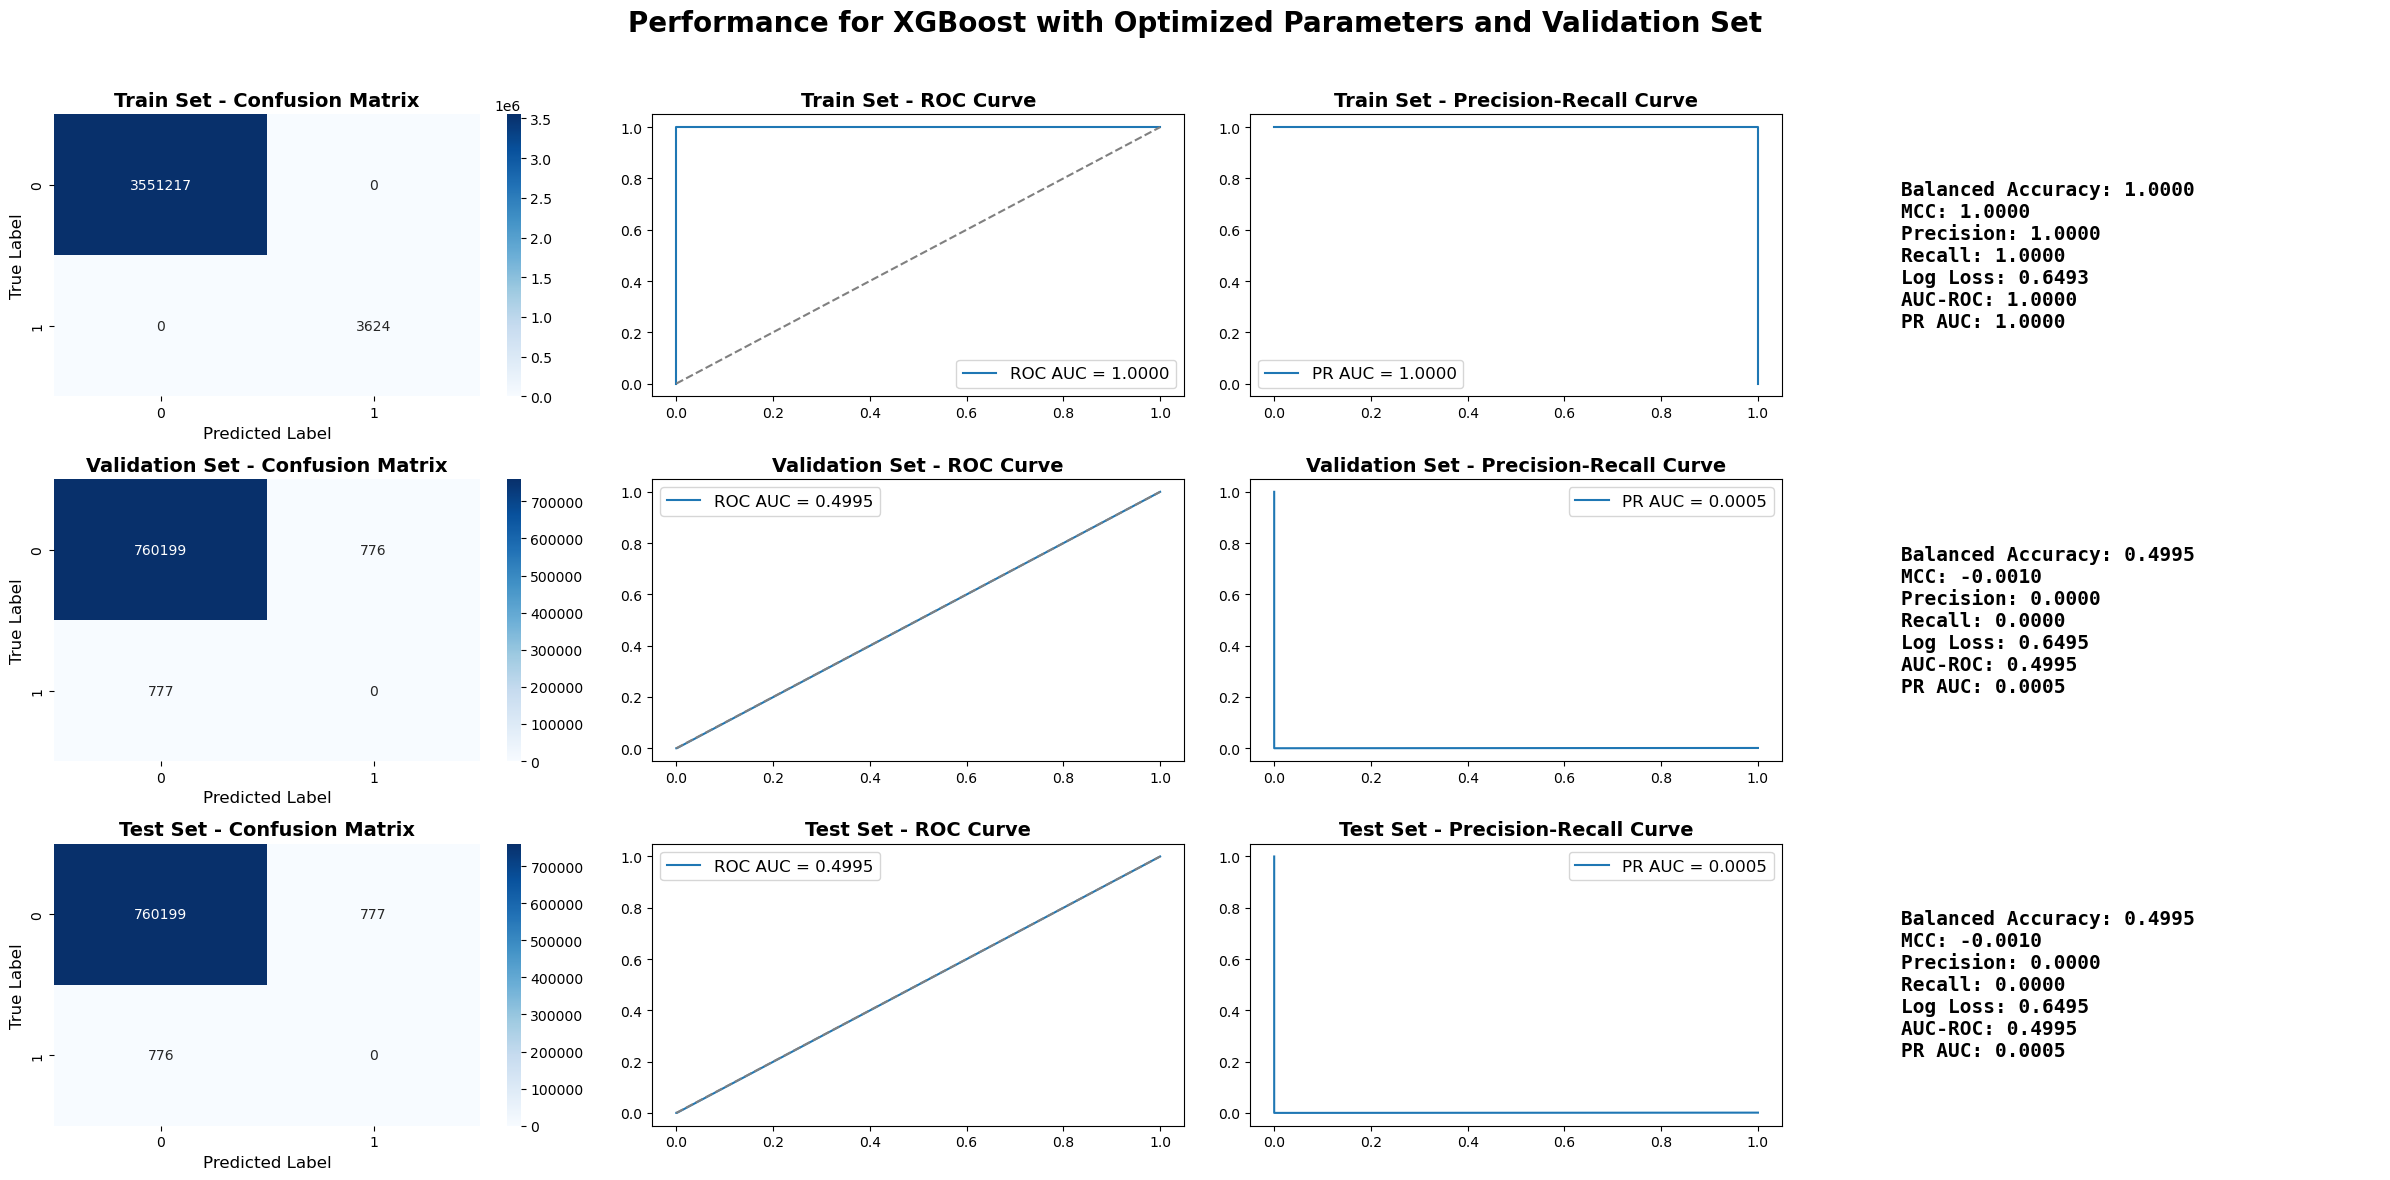

[INFO] Model Evaluation Completed.


⏱️ Execution time: 5.94s

⏱️ Execution time: 5.94s


In [17]:

# Evaluate Model Performance
slide_title = "Performance for XGBoost with Optimized Parameters and Validation Set"
print("[INFO] Evaluating Model Performance...")

metrics_summary = xgb2_pipeline.result_metrics(
    slide_title,
    y_train, train_pred, train_proba,
    y_val, val_pred, val_proba,
    y_test, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)

print("[INFO] Model Evaluation Completed.")
